In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [2]:
'''
Loading
'''

atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

graph_all = nice.graph.graph_from_json('Data/graph_100k.json')
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')
graph_nacs = nice.graph.graph_from_json('Data/graph_nacs_100k.json')

paths_all = json.load(open('Data/paths_100k.json', 'r'))
paths_ccs = json.load(open('Data/paths_ccs_100k.json', 'r'))
paths_nacs = json.load(open('Data/paths_nacs_100k.json', 'r'))

In [3]:
'''
Selecting
'''

graph = graph_ccs
paths = paths_ccs

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']

paths = [p for p in paths if len(p['path']) > 2]

places = [k for k, n in graph._node.items() if 'station' not in k]
stations = [k for k, n in graph._node.items() if 'station' in k]

In [4]:
threshold = 20 * 60

local_stations = []

for source in places:
    for target in stations:
        if graph._adj[source].get(target, {'cost': np.inf})['cost'] <= threshold:

            local_stations.append(target)

In [5]:
'''
Setting travel demand
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
    # 'remove_function': lambda x: nice.demand.within_range(x, 550, 75 * 3.6e6),
}

graph = nice.demand.demand(graph, places, **kw)

In [11]:
'''
Adding charging information at stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))

delta = 0

for station in stations:

    node = graph._node[station]

    power = node['power_kw'] * 1e3
    m = 1 / (energy / power)
    n = node['port_count']

    # lower_bound = n
    # upper_bound = n + delta if n > 4 else n
    # c = list(range(lower_bound, upper_bound + 1, 10))
    
    c = [n]
    queue = nice.queue.Queue(m = m, rho = rho, c = c)
    
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    counts = np.array([c for c in c])
    expenditure = np.array([c - n for c in c])
    base_volume = (
        .5 * volumes.max() * (station in local_stations)
    )

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays)
    graph._node[station]['counts'] = counts
    graph._node[station]['expenditures'] = expenditure
    graph._node[station]['base_volume'] = base_volume

In [12]:
'''
Adding classes and Building the network
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']
        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Objects Built: 2.3124005794525146
Sets Built: 0.05447125434875488
Parameters Built: 1.2623388767242432
Variables Built: 0.5565299987792969
Constraints Built: 0.2205202579498291
Expenditure Built: 0.025825023651123047
Objective Built: 0.1317133903503418


In [13]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 600,
    },
}

scale = 2e4 / 3600
# scale = 1 / 3600 / 1e3

network.model.scale = scale
network.model.penalty = 1
network.model.expenditure = 0
# network.model.expenditure_cost = 0

# for station in stations:

#     new_vol = (
#         rng.uniform(.5, .5) *
#         network.graph._node[station]['object'].volumes.max() *
#         (station in local_stations)
#     )
#     # print(new_vol / network.graph._node[station]['object'].volumes.max())

#     setattr(network.model, f'{station}::base_volume', new_vol)

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value)

Problem Solved: 1.5437960624694824
Results Collected: 0.4784247875213623
Objective Value: 15361.816362502592


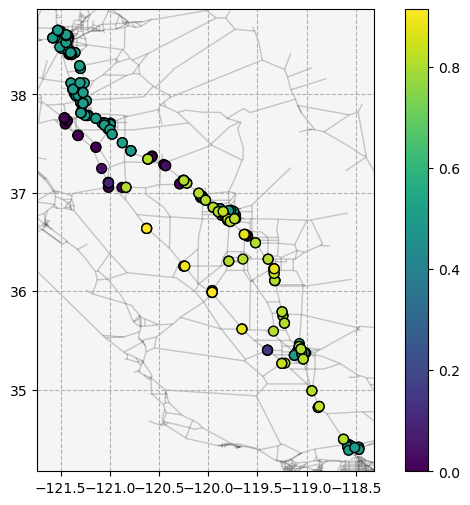

In [14]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600
    node['delta'] = node.get('selection', 0) - node.get('port_count', 0)
    # node['optimal_ports'] = node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['selection'] > 0]
        ),
        # 'selection': stations,
        'field': 'port_count',
        # 'field': 'delay',
        'field': 'utilization',
        # 'field': 'delta',
        # 'field': 'selection',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

In [10]:
num = sum(
    [n.get('mode_switch', 0) for n in solution._node.values()]
)

den = sum(
    [n.get('total', 0) for n in solution._node.values()]
)

ratio = np.nan_to_num(num / den)

scale, ratio

(5.555555555555555, 0.40123200049475766)

In [79]:
min_cost = 0

for source, node in graph._node.items():
    if source in places:
        for target, cost in node['free_flow'].items():

            min_cost += cost * node['flows'][target]

max_cost = 0

for source, node in graph._node.items():
    if source in places:
        for target, cost in node['mode_switch'].items():

            max_cost += cost * node['flows'][target]

min_cost / 3600, max_cost / 3600

(0.3714282683820871, 1.1872161938509922)

In [60]:
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')

graph_ccs_100 = graph_ccs

for k, n in graph_ccs_100._node.items():
    if 'port_count' in n:

        n['port_count'] = solution._node[k]['selection']

nice.graph.graph_to_json(graph_ccs_100, 'Data/graph_ccs_100.json')

sum([n.get('port_count', 0) for n in graph_ccs_100._node.values()])

1129

In [56]:
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')

graph_ccs_200 = graph_ccs

for k, n in graph_ccs_200._node.items():
    if 'port_count' in n:

        n['port_count'] = solution._node[k]['selection']

nice.graph.graph_to_json(graph_ccs_200, 'Data/graph_ccs_200.json')

sum([n.get('port_count', 0) for n in graph_ccs_200._node.values()])

1229

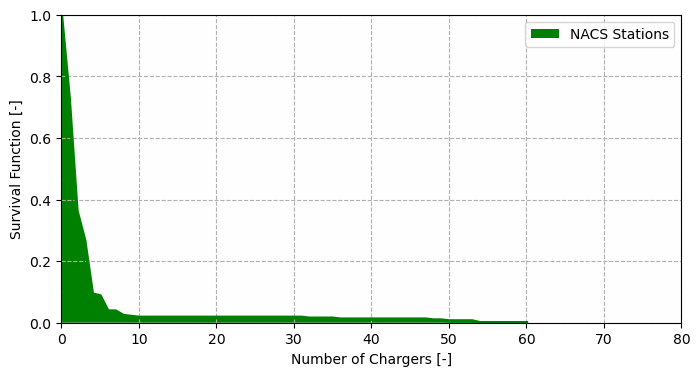

In [30]:
fig, ax = plt.subplots(figsize = (8, 4))

selection = [s for s in stations if solution._node[s]['selection'] > 0]

x = np.arange(0, 61, 1)
s = np.array([solution._node[s]['selection'] for s in selection])
y = np.array([sum(s > x) / len(s) for x in x])

kw = {
    'lw': 2.5,
    'c': 'green',
}

ax.plot(x, y, **kw)

kw = {
    'fc': 'green',
    # 'alpha': .5,
    'label': 'NACS Stations',
}

ax.fill_between(x, y, **kw)

# x = np.arange(0, 81, 1)
# s = np.array([n['port_count'] for n in graph._node.values()])
# y = np.array([sum(s > x) / len(s) for x in x])

# kw = {
#     'lw': 2.5,
#     'c': 'k',
# }

# ax.plot(x, y, **kw)

# kw = {
#     'fc': 'k',
#     # 'alpha': .5,
#     'label': 'CCS Stations',
# }

# ax.fill_between(x, y, **kw)

kw = {
    'xlim': (0, 80),
    'ylim': (0, 1),
    'xlabel': 'Number of Chargers [-]',
    'ylabel': 'Survival Function [-]',
    'facecolor': '#fefefe',
}

_ = ax.set(**kw)

kw = {
    'ls': '--',
}

_ = ax.grid(**kw)

_ = ax.legend()

# fig.savefig(
#     'Paper/figures/stations_survival.png', bbox_inches = 'tight', dpi = 300
# )

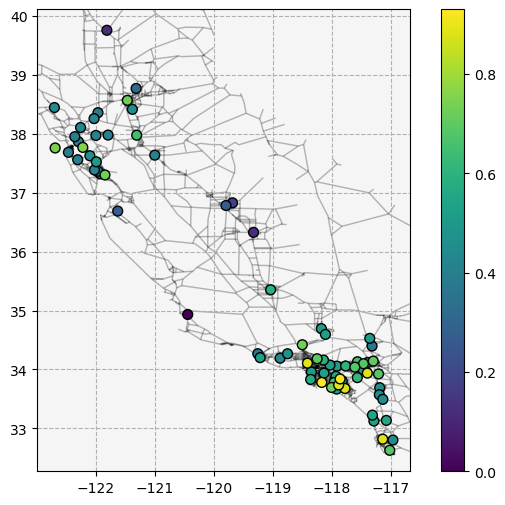

In [16]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'nodes': {
        'selection': list(places),
        'field': 'mode_switch_portion',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .15,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

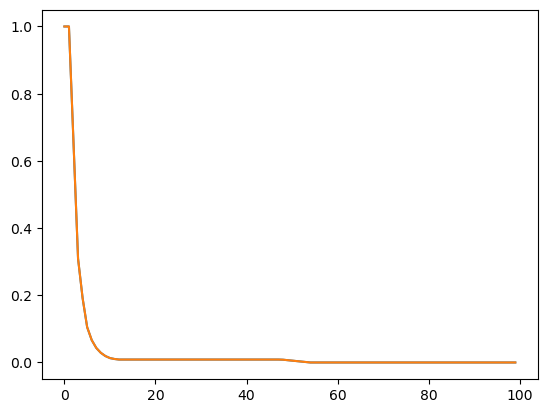

In [30]:
from scipy.stats import rv_histogram

pcs = np.array(
    [n['port_count'] for k, n in graph._node.items() if k in stations]
)

pcs_o = np.array(
    [n['selection'] for k, n in solution._node.items() if k in stations]
)

x = np.arange(0, 100, 1)
bins = 25

plt.plot(x, rv_histogram(np.histogram(pcs, bins = bins)).sf(x))
plt.plot(x, rv_histogram(np.histogram(pcs_o, bins = bins)).sf(x))

(array([253.,  79.,  15.,   7.,   7.,   4.,   1.,   3.,   1.,   2.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   2.,   0.,
          3.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   2.02,   4.04,   6.06,   8.08,  10.1 ,  12.12,  14.14,
         16.16,  18.18,  20.2 ,  22.22,  24.24,  26.26,  28.28,  30.3 ,
         32.32,  34.34,  36.36,  38.38,  40.4 ,  42.42,  44.44,  46.46,
         48.48,  50.5 ,  52.52,  54.54,  56.56,  58.58,  60.6 ,  62.62,
         64.64,  66.66,  68.68,  70.7 ,  72.72,  74.74,  76.76,  78.78,
         80.8 ,  82.82,  84.84,  86.86,  88.88,  90.9 ,  92.92,  94.94,
         96.96,  98.98, 101.  ]),
 <BarContainer object of 50 artists>)

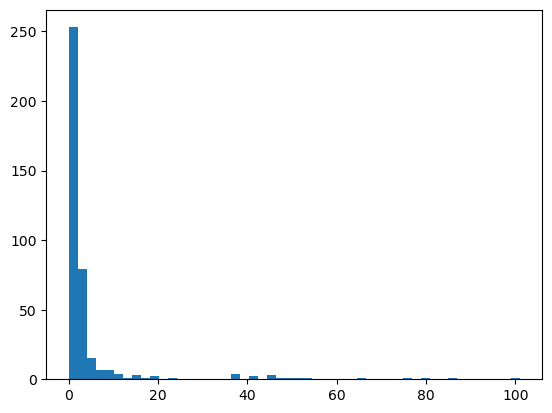

In [54]:
pcs = np.array(
    [n['optimal_ports'] for k, n in solution._node.items() if k in stations]
)

plt.hist(pcs, bins = 50)

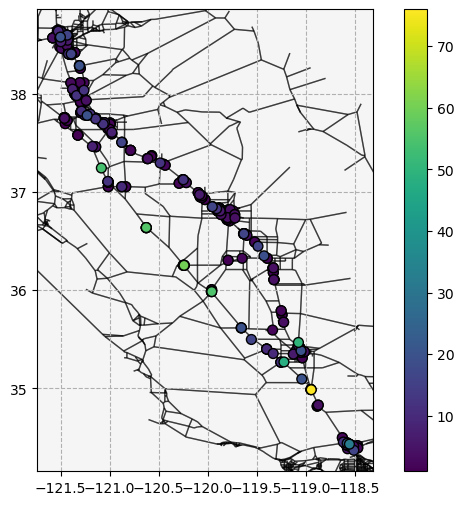

In [95]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600
    node['optimal_ports'] = node.get('port_count', 0) + node.get('selection', 0) 

kw = {
    'nodes': {
        'selection': list(stations),
        'field': 'port_count',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .5,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

In [78]:
solution._node['Berkeley, CA']

{'x': -122.29891000959519,
 'y': 37.86639200970123,
 'population': 118715.0,
 'type': 'place',
 'flows': {'Temecula, CA': 4.2327670842863725e-06,
  'Visalia, CA': 2.8623492655560376e-05,
  'Santa Clara, CA': 8.462835498359203e-05,
  'San Bernardino, CA': 1.0625852651285913e-05,
  'Los Angeles, CA': 0.0002757771616710159,
  'Thousand Oaks, CA': 7.995558545725571e-06,
  'Victorville, CA': 7.490194862947106e-06,
  'Oxnard, CA': 1.5387232905938042e-05,
  'Santa Maria, CA': 1.64679464497375e-05,
  'Santa Rosa, CA': 0.00010896272526578483,
  'Salinas, CA': 7.143947006601026e-05,
  'Hayward, CA': 0.00012117922311553539,
  'Hesperia, CA': 5.132514738760504e-06,
  'Antioch, CA': 8.06980368514648e-05,
  'Garden Grove, CA': 9.491308914167563e-06,
  'Glendale, CA': 1.3408242051003453e-05,
  'Torrance, CA': 8.828272615000574e-06,
  'Fontana, CA': 1.077029487898499e-05,
  'San Jose, CA': 0.0006204527184585034,
  'Rialto, CA': 5.164324921402771e-06,
  'Escondido, CA': 5.009249399026896e-06,
  'Vallej